# NB07: Essential Dark Gene Prioritization & Gene Neighbor Analysis

**Problem**: 9,557 essential dark genes (55% of 17,344 experimentally actionable dark genes) score 0/100 in the NB05 top candidates because the scoring framework relies on fitness magnitude, which essentials lack (no viable mutants = no fitness data). These genes need a separate ranking methodology.

**New analyses**:
1. **Gene neighbor analysis** — infer function from genomic context (annotated operon partners) using FB positional data
2. **Essential dark gene scoring** — separate framework using phylogenetic breadth, neighbor context, domains, cross-organism conservation, and CRISPRi tractability
3. **Top-50 essential dossiers** — experimentally actionable candidates with specific CRISPRi experiments

**Requires**: BERDL JupyterHub (Spark access for FB gene table + ortholog queries)

**Inputs**: `data/dark_genes_integrated.tsv` (NB01), `data/phylogenetic_breadth.tsv` (NB02)

**Outputs**: `data/gene_neighbor_context.tsv`, `data/essential_dark_scored.tsv`, `data/essential_prioritized_candidates.tsv`, `figures/fig18_neighbor_analysis.png`, `figures/fig19_essential_scores.png`, `figures/fig20_essential_top20.png`

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Spark session
spark = get_spark_session()

# Project paths
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_DIR = os.path.dirname(os.getcwd())
else:
    PROJECT_DIR = os.getcwd()

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

print(f'Project dir: {PROJECT_DIR}')

Project dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter


In [2]:
# Load NB01 unified table
unified = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_integrated.tsv'), sep='\t', low_memory=False)
unified['locusId'] = unified['locusId'].astype(str)
dark = unified[unified['is_dark'] == True].copy()
essential_dark = dark[dark['is_essential_dark'] == True].copy()

# Load phylogenetic breadth from NB02
phylo = pd.read_csv(os.path.join(DATA_DIR, 'phylogenetic_breadth.tsv'), sep='\t')

print(f'Unified table: {len(unified):,} genes')
print(f'Dark genes: {len(dark):,}')
print(f'Essential dark genes: {len(essential_dark):,}')
print(f'Phylogenetic breadth entries: {len(phylo):,}')
print(f'\nEssential dark genes by organism (top 10):')
print(essential_dark['orgId'].value_counts().head(10))

Unified table: 228,709 genes
Dark genes: 57,011
Essential dark genes: 9,557
Phylogenetic breadth entries: 30,756

Essential dark genes by organism (top 10):
orgId
azobra            609
Dino              504
BFirm             472
Miya              460
pseudo1_N1B4      455
Burk376           389
Magneto           342
DvH               326
Smeli             323
RalstoniaUW163    265
Name: count, dtype: int64


## Section 1: Gene Neighbor Analysis

For each dark gene, identify its genomic neighbors using FB `gene` table positional data (`scaffoldId`, `begin`, `end`, `strand`). Annotated neighbors in the same operon provide the strongest functional clues for genes of unknown function.

In [3]:
# Query FB gene table with full positional data
# NB01 only loaded orgId, locusId, sysName, gene, desc — we need scaffoldId, begin, end, strand
fb_genes = spark.sql("""
    SELECT orgId, locusId, sysName, gene, desc,
           scaffoldId, CAST(begin AS INT) as begin_pos, CAST(end AS INT) as end_pos, strand
    FROM kescience_fitnessbrowser.gene
""").toPandas()

fb_genes['locusId'] = fb_genes['locusId'].astype(str)

print(f'FB genes with positions: {len(fb_genes):,}')
print(f'Organisms: {fb_genes["orgId"].nunique()}')
print(f'Genes with valid positions: {fb_genes["begin_pos"].notna().sum():,}')
print(f'Genes with scaffold: {fb_genes["scaffoldId"].notna().sum():,}')

FB genes with positions: 228,709
Organisms: 48
Genes with valid positions: 228,709
Genes with scaffold: 228,709


In [4]:
# Mark which genes are dark
dark_set = set(zip(dark['orgId'], dark['locusId']))
essential_set = set(zip(essential_dark['orgId'], essential_dark['locusId']))
fb_genes['is_dark'] = fb_genes.apply(lambda r: (r['orgId'], r['locusId']) in dark_set, axis=1)
fb_genes['is_essential_dark'] = fb_genes.apply(lambda r: (r['orgId'], r['locusId']) in essential_set, axis=1)

# Classify annotation status of each gene based on desc
def classify_desc(desc):
    """Classify gene description as annotated or dark."""
    if pd.isna(desc) or desc.strip() == '':
        return 'no_annotation'
    desc_lower = desc.lower()
    if 'hypothetical' in desc_lower:
        return 'hypothetical'
    if 'duf' in desc_lower:
        return 'DUF'
    if 'uncharacterized' in desc_lower or 'unknown' in desc_lower:
        return 'uncharacterized'
    return 'annotated'

fb_genes['annot_class'] = fb_genes['desc'].apply(classify_desc)

print(f'Annotation classes in FB gene table:')
print(fb_genes['annot_class'].value_counts())

Annotation classes in FB gene table:
annot_class
annotated          171354
hypothetical        48710
DUF                  3675
uncharacterized      3594
no_annotation        1376
Name: count, dtype: int64


In [5]:
# For each dark gene, find N=5 upstream + 5 downstream neighbors on the same scaffold
# Predict operon membership: same strand, gap < 300bp

NEIGHBOR_WINDOW = 5
OPERON_MAX_GAP = 300  # bp

# Sort genes per organism per scaffold by position
fb_genes_sorted = fb_genes.dropna(subset=['begin_pos', 'scaffoldId']).sort_values(
    ['orgId', 'scaffoldId', 'begin_pos']
).reset_index(drop=True)

# Build positional index: for each organism+scaffold, list of gene indices in order
scaffold_groups = fb_genes_sorted.groupby(['orgId', 'scaffoldId']).groups

# For efficient lookup, build a dict of (orgId, locusId) -> position in sorted array
gene_to_idx = {}
for idx, row in fb_genes_sorted.iterrows():
    gene_to_idx[(row['orgId'], row['locusId'])] = idx

print(f'Genes with positions indexed: {len(gene_to_idx):,}')
print(f'Scaffold groups: {len(scaffold_groups):,}')

Genes with positions indexed: 228,709
Scaffold groups: 174


In [6]:
# Extract neighbors for all dark genes
neighbor_results = []

for org_id in dark['orgId'].unique():
    org_dark = dark[dark['orgId'] == org_id]
    
    for _, drow in org_dark.iterrows():
        locus = drow['locusId']
        key = (org_id, locus)
        
        if key not in gene_to_idx:
            continue
        
        idx = gene_to_idx[key]
        target_gene = fb_genes_sorted.loc[idx]
        scaffold = target_gene['scaffoldId']
        target_strand = target_gene['strand']
        target_end = target_gene['end_pos']
        target_begin = target_gene['begin_pos']
        
        # Get all genes on this scaffold for this organism
        scaffold_key = (org_id, scaffold)
        if scaffold_key not in scaffold_groups:
            continue
        
        scaffold_indices = scaffold_groups[scaffold_key]
        pos_in_scaffold = list(scaffold_indices).index(idx)
        
        # Get window of neighbors
        start_pos = max(0, pos_in_scaffold - NEIGHBOR_WINDOW)
        end_pos = min(len(scaffold_indices), pos_in_scaffold + NEIGHBOR_WINDOW + 1)
        neighbor_indices = [scaffold_indices[i] for i in range(start_pos, end_pos) if scaffold_indices[i] != idx]
        
        neighbors = fb_genes_sorted.loc[neighbor_indices]
        
        # Classify neighbors
        n_annotated = (neighbors['annot_class'] == 'annotated').sum()
        n_dark_neighbors = (neighbors['annot_class'] != 'annotated').sum()
        n_total = len(neighbors)
        
        # Annotated neighbor descriptions
        annot_neighbors = neighbors[neighbors['annot_class'] == 'annotated']
        annot_descs = annot_neighbors['desc'].tolist()
        annot_genes = annot_neighbors['gene'].dropna().tolist()
        
        # Operon prediction: same strand, close spacing
        operon_partners = []
        for _, nrow in neighbors.iterrows():
            if nrow['strand'] == target_strand:
                # Check gap
                if nrow['begin_pos'] > target_end:
                    gap = nrow['begin_pos'] - target_end
                elif target_begin > nrow['end_pos']:
                    gap = target_begin - nrow['end_pos']
                else:
                    gap = 0  # overlapping
                
                if gap <= OPERON_MAX_GAP:
                    operon_partners.append({
                        'locusId': nrow['locusId'],
                        'gene': nrow['gene'],
                        'desc': nrow['desc'],
                        'is_annotated': nrow['annot_class'] == 'annotated',
                        'gap_bp': gap,
                    })
        
        # Functional categories from annotated neighbors
        func_keywords = []
        for desc in annot_descs:
            if pd.notna(desc):
                desc_lower = desc.lower()
                for kw in ['transport', 'kinase', 'reductase', 'dehydrogenase', 'synthase',
                           'transferase', 'permease', 'oxidase', 'lyase', 'protease',
                           'regulator', 'transcription', 'ribosom', 'membrane', 'flagell',
                           'chemotaxis', 'secretion', 'peptidase', 'hydrolase', 'ligase',
                           'isomerase', 'recombinase', 'helicase', 'polymerase',
                           'atp', 'nad', 'iron', 'sulfur', 'nitrogen', 'phospho']:
                    if kw in desc_lower:
                        func_keywords.append(kw)
        
        # Summarize operon context
        operon_annotated = [p for p in operon_partners if p['is_annotated']]
        operon_descs = [p['desc'] for p in operon_annotated if pd.notna(p['desc'])]
        operon_genes = [p['gene'] for p in operon_partners if pd.notna(p.get('gene'))]
        
        neighbor_results.append({
            'orgId': org_id,
            'locusId': locus,
            'scaffoldId': scaffold,
            'begin_pos': target_begin,
            'strand': target_strand,
            'n_neighbors': n_total,
            'n_annotated_neighbors': n_annotated,
            'n_dark_neighbors': n_dark_neighbors,
            'annotated_neighbor_frac': n_annotated / n_total if n_total > 0 else 0,
            'n_operon_partners': len(operon_partners),
            'n_operon_annotated': len(operon_annotated),
            'operon_genes': '; '.join(operon_genes[:5]) if operon_genes else '',
            'operon_annotated_descs': ' | '.join(operon_descs[:3]) if operon_descs else '',
            'annotated_neighbor_descs': ' | '.join(annot_descs[:3]) if annot_descs else '',
            'annotated_neighbor_genes': '; '.join([str(g) for g in annot_genes[:5]]) if annot_genes else '',
            'func_keywords': '; '.join(sorted(set(func_keywords))) if func_keywords else '',
            'neighbor_functional_inference': operon_descs[0] if operon_descs else (annot_descs[0] if annot_descs else ''),
        })

neighbor_df = pd.DataFrame(neighbor_results)
print(f'Gene neighbor analysis complete: {len(neighbor_df):,} dark genes processed')
print(f'  With annotated neighbors: {(neighbor_df["n_annotated_neighbors"] > 0).sum():,}')
print(f'  With operon partners: {(neighbor_df["n_operon_partners"] > 0).sum():,}')
print(f'  With annotated operon partners: {(neighbor_df["n_operon_annotated"] > 0).sum():,}')
print(f'  With functional inference: {(neighbor_df["neighbor_functional_inference"] != "").sum():,}')

Gene neighbor analysis complete: 57,011 dark genes processed
  With annotated neighbors: 55,422
  With operon partners: 45,848
  With annotated operon partners: 30,190
  With functional inference: 55,422


In [7]:
# Save gene neighbor context
neighbor_df.to_csv(os.path.join(DATA_DIR, 'gene_neighbor_context.tsv'), sep='\t', index=False)
print(f'Saved gene_neighbor_context.tsv ({len(neighbor_df):,} entries)')

# Summary statistics
print(f'\nNeighbor statistics:')
print(f'  Mean annotated neighbor fraction: {neighbor_df["annotated_neighbor_frac"].mean():.3f}')
print(f'  Mean operon partners: {neighbor_df["n_operon_partners"].mean():.1f}')
print(f'\nTop functional keywords from neighbors:')
all_kw = []
for kws in neighbor_df['func_keywords']:
    if kws:
        all_kw.extend(kws.split('; '))
kw_counts = Counter(all_kw).most_common(15)
for kw, n in kw_counts:
    print(f'  {kw}: {n:,}')

Saved gene_neighbor_context.tsv (57,011 entries)

Neighbor statistics:
  Mean annotated neighbor fraction: 0.636
  Mean operon partners: 1.3

Top functional keywords from neighbors:
  regulator: 23,598
  transcription: 20,375
  transferase: 20,000
  transport: 19,200
  membrane: 12,141
  reductase: 11,654
  dehydrogenase: 11,259
  atp: 11,101
  phospho: 9,982
  kinase: 9,709
  synthase: 8,727
  hydrolase: 8,557
  permease: 6,796
  peptidase: 6,082
  nad: 4,526


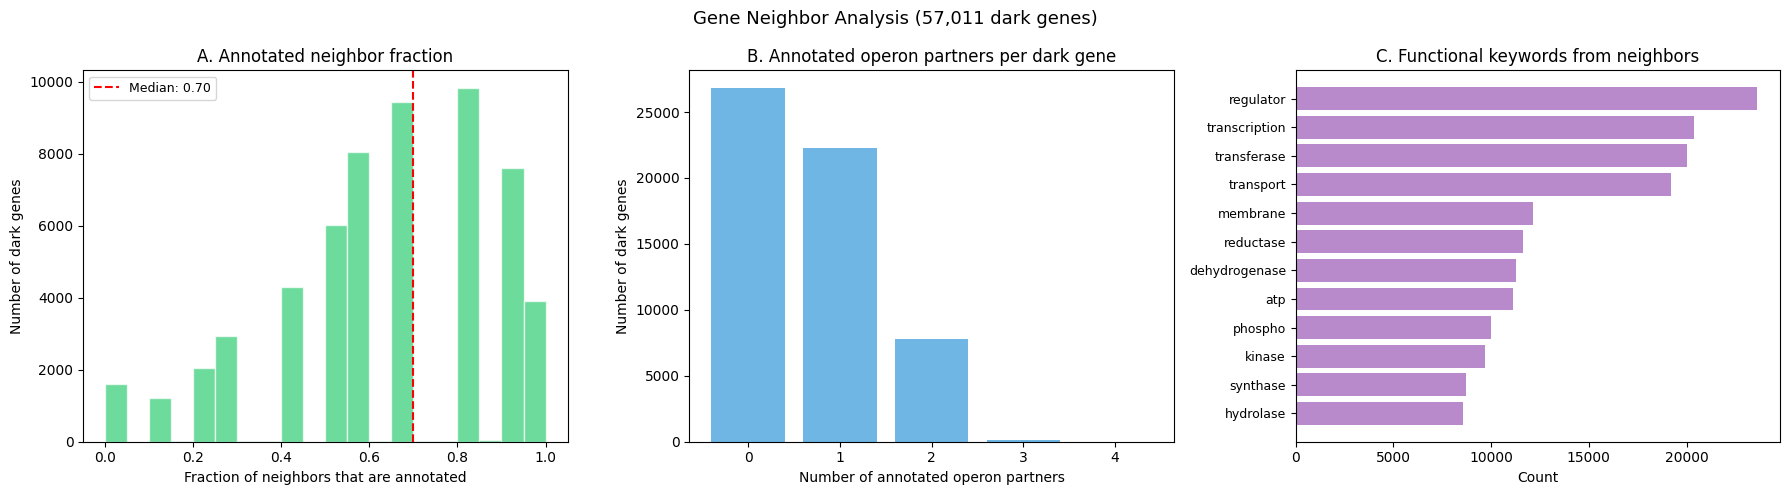

Saved fig18_neighbor_analysis.png


In [8]:
# Figure 18: Gene neighbor analysis summary
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel A: Annotated neighbor fraction distribution
ax = axes[0]
ax.hist(neighbor_df['annotated_neighbor_frac'], bins=20, color='#2ecc71', alpha=0.7, edgecolor='white')
ax.set_xlabel('Fraction of neighbors that are annotated')
ax.set_ylabel('Number of dark genes')
ax.set_title('A. Annotated neighbor fraction')
ax.axvline(x=neighbor_df['annotated_neighbor_frac'].median(), color='red', linestyle='--',
           label=f'Median: {neighbor_df["annotated_neighbor_frac"].median():.2f}')
ax.legend(fontsize=9)

# Panel B: Operon partner counts
ax = axes[1]
operon_counts = neighbor_df['n_operon_annotated'].value_counts().sort_index()
ax.bar(operon_counts.index, operon_counts.values, color='#3498db', alpha=0.7)
ax.set_xlabel('Number of annotated operon partners')
ax.set_ylabel('Number of dark genes')
ax.set_title('B. Annotated operon partners per dark gene')

# Panel C: Top functional keywords
ax = axes[2]
if kw_counts:
    kws, counts = zip(*kw_counts[:12])
    y_pos = range(len(kws))
    ax.barh(y_pos, counts, color='#9b59b6', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(kws, fontsize=9)
    ax.set_xlabel('Count')
    ax.set_title('C. Functional keywords from neighbors')
    ax.invert_yaxis()

plt.suptitle(f'Gene Neighbor Analysis ({len(neighbor_df):,} dark genes)', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig18_neighbor_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig18_neighbor_analysis.png')

## Section 2: Essential Dark Gene Scoring Framework

Scoring dimensions designed for genes that lack fitness magnitude data:

| Dimension | Weight | Rationale |
|-----------|--------|-----------|
| Gene neighbor context | 0.25 | Operon membership with annotated genes = strongest functional clue |
| Cross-organism conservation | 0.20 | Conserved essential across diverse organisms = fundamental function |
| Phylogenetic breadth | 0.20 | Widespread across bacterial phyla = highest-priority unknowns |
| Domain annotations | 0.15 | DUF/PFam domains provide structural hints |
| CRISPRi tractability | 0.20 | Experimentally actionable prioritization |

In [9]:
# Query ortholog table for essential dark genes: how many FB organisms have the same ortholog?
ess_loci = essential_dark[['orgId', 'locusId']].drop_duplicates()
ess_spark = spark.createDataFrame(
    [(str(r['orgId']), str(r['locusId'])) for _, r in ess_loci.iterrows()],
    ['orgId', 'locusId']
)
ess_spark.createOrReplaceTempView('essential_loci')

# Get ortholog counts per essential dark gene
ess_orthologs = spark.sql("""
    SELECT el.orgId, el.locusId,
           COUNT(DISTINCT o.orgId2) as n_ortholog_organisms
    FROM essential_loci el
    LEFT JOIN kescience_fitnessbrowser.ortholog o
        ON el.orgId = o.orgId1 AND el.locusId = o.locusId1
    GROUP BY el.orgId, el.locusId
""").toPandas()

print(f'Essential dark genes with ortholog data: {len(ess_orthologs):,}')
print(f'With orthologs in other FB organisms: {(ess_orthologs["n_ortholog_organisms"] > 0).sum():,}')
print(f'\nOrtholog organism count distribution:')
print(ess_orthologs['n_ortholog_organisms'].describe())

Essential dark genes with ortholog data: 9,557
With orthologs in other FB organisms: 3,892

Ortholog organism count distribution:
count    9557.000000
mean        2.751805
std         6.356354
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        45.000000
Name: n_ortholog_organisms, dtype: float64


In [10]:
# CRISPRi tractability scoring
# Literature-based assessment of CRISPRi/dCas9 availability per organism
CRISPRI_TRACTABILITY = {
    # High: published CRISPRi protocols with validated dCas9 systems
    'Keio': 0.9,        # E. coli - gold standard
    'BW25113': 0.9,     # E. coli BW25113
    'Deshi': 0.85,      # E. coli
    'MR1': 0.8,         # Shewanella MR-1 - CRISPRi established (Peters et al. 2019)
    'SB2B': 0.7,        # Shewanella
    'Putida': 0.8,      # P. putida KT2440 - CRISPRi available (Tan et al. 2018)
    'pseudo5_N2C3_1': 0.75,  # P. putida N2C3
    'pseudo1_N1B4': 0.7,     # P. fluorescens
    'pseudo3_N2E2': 0.7,     # P. simiae
    'pseudo13_GW456_L13': 0.65,
    'Pse': 0.7,         # Pseudomonas
    'Pseu': 0.7,
    'BT': 0.75,         # B. thetaiotaomicron - CRISPRi available (Mimee et al. 2015)
    'Bacteroides_theta': 0.75,
    'Smeli': 0.6,       # S. meliloti - some genetic tools
    'Koxy': 0.65,       # Klebsiella
    'Marino': 0.5,      # Marinobacter - less developed
    'DvH': 0.5,         # D. vulgaris Hildenborough
    'Geobacter': 0.45,  # Geobacter
    'Caulobacter': 0.6, # Caulobacter
    'Synpcc7942': 0.55, # Synechococcus
    'Synpcc6803': 0.55, # Synechocystis
    'psRCH2': 0.55,     # P. stutzeri RCH2
    'Rleg': 0.5,        # Rhizobium
}
# Default for organisms not listed
DEFAULT_CRISPRI = 0.3

print(f'CRISPRi tractability scores for {len(CRISPRI_TRACTABILITY)} organisms')
print(f'Default for unlisted organisms: {DEFAULT_CRISPRI}')

CRISPRi tractability scores for 24 organisms
Default for unlisted organisms: 0.3


In [11]:
# Merge all evidence for essential dark genes
ess_scored = essential_dark[['orgId', 'locusId', 'desc', 'annotation_class',
                              'gene_cluster_id', 'is_core', 'is_auxiliary',
                              'has_pangenome_link', 'module', 'in_module',
                              'module_prediction', 'OG_id', 'has_ortholog',
                              'essentiality_class', 'essential_prediction',
                              'n_domains', 'domain_names', 'domain_dbs',
                              'top_cofit_partners', 'top_cofit_score']].copy()

# Merge neighbor context
ess_scored = ess_scored.merge(
    neighbor_df[['orgId', 'locusId', 'n_annotated_neighbors', 'n_operon_partners',
                 'n_operon_annotated', 'annotated_neighbor_frac',
                 'operon_annotated_descs', 'annotated_neighbor_descs',
                 'func_keywords', 'neighbor_functional_inference']],
    on=['orgId', 'locusId'], how='left'
)

# Merge ortholog counts
ess_scored = ess_scored.merge(
    ess_orthologs[['orgId', 'locusId', 'n_ortholog_organisms']],
    on=['orgId', 'locusId'], how='left'
)

# Merge phylogenetic breadth
phylo_subset = phylo[['gene_cluster_id', 'breadth_class', 'n_tax_levels', 'n_species', 'COG_category']]
ess_scored = ess_scored.merge(
    phylo_subset, on='gene_cluster_id', how='left'
)

print(f'Essential dark genes with all evidence: {len(ess_scored):,}')
print(f'  With neighbor data: {ess_scored["n_annotated_neighbors"].notna().sum():,}')
print(f'  With ortholog data: {ess_scored["n_ortholog_organisms"].notna().sum():,}')
print(f'  With phylo breadth: {ess_scored["breadth_class"].notna().sum():,}')

Essential dark genes with all evidence: 9,557
  With neighbor data: 9,557
  With ortholog data: 9,557
  With phylo breadth: 4,337


In [12]:
# Scoring functions for essential dark genes

ESSENTIAL_WEIGHTS = {
    'neighbor': 0.25,
    'conservation': 0.20,
    'breadth': 0.20,
    'domains': 0.15,
    'tractability': 0.20,
}
assert abs(sum(ESSENTIAL_WEIGHTS.values()) - 1.0) < 1e-6

def _safe_float(val, default=0.0):
    if val is None:
        return default
    try:
        f = float(val)
        return default if np.isnan(f) else f
    except (ValueError, TypeError):
        return default

def _safe_int(val, default=0):
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return default
    try:
        return int(val)
    except (ValueError, TypeError):
        return default


def score_ess_neighbor(row):
    """Score gene neighbor context (0-1). Weight: 0.25."""
    score = 0.0
    
    # Annotated operon partners (strongest signal) (0-0.5)
    n_op_annot = _safe_int(row.get('n_operon_annotated', 0))
    score += min(n_op_annot * 0.2, 0.5)
    
    # Overall annotated neighbor fraction (0-0.3)
    annot_frac = _safe_float(row.get('annotated_neighbor_frac', 0))
    score += annot_frac * 0.3
    
    # Has functional inference from neighbors (0.2)
    inference = str(row.get('neighbor_functional_inference', ''))
    if inference and inference != '' and inference != 'nan':
        score += 0.2
    
    return min(score, 1.0)


def score_ess_conservation(row):
    """Score cross-organism conservation (0-1). Weight: 0.20."""
    score = 0.0
    
    # Number of FB organisms with ortholog (0-0.6)
    n_orgs = _safe_int(row.get('n_ortholog_organisms', 0))
    score += min(n_orgs / 20.0, 0.6)  # Cap at 20 organisms
    
    # Has ortholog at all (0.2)
    if n_orgs > 0:
        score += 0.2
    
    # Module membership (provides functional context even without fitness) (0.2)
    if row.get('in_module') == True:
        pred = str(row.get('module_prediction', ''))
        if pred and pred not in ('', 'nan'):
            score += 0.2
        else:
            score += 0.1
    
    return min(score, 1.0)


def score_ess_breadth(row):
    """Score phylogenetic breadth (0-1). Weight: 0.20."""
    score = 0.0
    
    # Species count from pangenome (0-0.5)
    n_species = _safe_int(row.get('n_species', 0))
    score += min(n_species / 30.0, 0.5)  # Cap at 30 species
    
    # Taxonomic levels (0-0.3)
    n_tax = _safe_int(row.get('n_tax_levels', 0))
    score += min(n_tax / 6.0, 0.3)
    
    # Has pangenome link at all (0.2)
    if row.get('has_pangenome_link') == True:
        score += 0.2
    
    return min(score, 1.0)


def score_ess_domains(row):
    """Score domain annotations (0-1). Weight: 0.15."""
    score = 0.0
    
    n_domains = _safe_int(row.get('n_domains', 0))
    if n_domains > 0:
        score += 0.4  # Has any domain hit
        score += min(n_domains * 0.15, 0.3)  # More domains = better
    
    # COG category (functional classification from eggNOG)
    cog = str(row.get('COG_category', ''))
    if cog and cog not in ('', 'nan', 'S', '-'):  # S = function unknown, - = none
        score += 0.3
    
    return min(score, 1.0)


def score_ess_tractability(row):
    """Score CRISPRi tractability (0-1). Weight: 0.20."""
    org = row.get('orgId', '')
    crispri_score = CRISPRI_TRACTABILITY.get(org, DEFAULT_CRISPRI)
    
    score = crispri_score  # 0-0.9 from organism tractability
    
    # Bonus for having characterized co-fitness partners (functional context for experiment design)
    partners = str(row.get('top_cofit_partners', ''))
    if partners and partners not in ('nan', ''):
        score += 0.1
    
    return min(score, 1.0)


print('Essential scoring functions defined.')
print(f'Weights: {ESSENTIAL_WEIGHTS}')

Essential scoring functions defined.
Weights: {'neighbor': 0.25, 'conservation': 0.2, 'breadth': 0.2, 'domains': 0.15, 'tractability': 0.2}


In [13]:
# Score all essential dark genes
ess_scores = []

for _, row in ess_scored.iterrows():
    s_nb = score_ess_neighbor(row)
    s_cons = score_ess_conservation(row)
    s_br = score_ess_breadth(row)
    s_dom = score_ess_domains(row)
    s_tr = score_ess_tractability(row)
    
    total = (
        s_nb * ESSENTIAL_WEIGHTS['neighbor'] +
        s_cons * ESSENTIAL_WEIGHTS['conservation'] +
        s_br * ESSENTIAL_WEIGHTS['breadth'] +
        s_dom * ESSENTIAL_WEIGHTS['domains'] +
        s_tr * ESSENTIAL_WEIGHTS['tractability']
    )
    
    ess_scores.append({
        'orgId': row['orgId'],
        'locusId': row['locusId'],
        'desc': row.get('desc', ''),
        'annotation_class': row.get('annotation_class', ''),
        'gene_cluster_id': row.get('gene_cluster_id', ''),
        'is_core': row.get('is_core', False),
        'module_prediction': row.get('module_prediction', ''),
        'essential_prediction': row.get('essential_prediction', ''),
        'n_domains': row.get('n_domains', 0),
        'domain_names': row.get('domain_names', ''),
        'n_ortholog_organisms': row.get('n_ortholog_organisms', 0),
        'n_operon_annotated': row.get('n_operon_annotated', 0),
        'neighbor_functional_inference': row.get('neighbor_functional_inference', ''),
        'operon_annotated_descs': row.get('operon_annotated_descs', ''),
        'func_keywords': row.get('func_keywords', ''),
        'n_species': row.get('n_species', 0),
        'COG_category': row.get('COG_category', ''),
        's_neighbor': s_nb,
        's_conservation': s_cons,
        's_breadth': s_br,
        's_domains': s_dom,
        's_tractability': s_tr,
        'total_score': total,
    })

ess_scores_df = pd.DataFrame(ess_scores)
ess_scores_df = ess_scores_df.sort_values('total_score', ascending=False).reset_index(drop=True)

print(f'Scored {len(ess_scores_df):,} essential dark genes')
print(f'\nScore distribution:')
print(ess_scores_df['total_score'].describe())
print(f'\nComponent score medians:')
for col in ['s_neighbor', 's_conservation', 's_breadth', 's_domains', 's_tractability']:
    name = col.replace('s_', '')
    nonzero = (ess_scores_df[col] > 0).sum()
    print(f'  {name:15s}: median={ess_scores_df[col].median():.3f}, '
          f'mean={ess_scores_df[col].mean():.3f}, '
          f'non-zero={nonzero} ({100*nonzero/len(ess_scores_df):.1f}%)')

Scored 9,557 essential dark genes

Score distribution:
count    9557.000000
mean        0.338114
std         0.173447
min         0.060000
25%         0.210000
50%         0.311667
75%         0.459167
max         0.875000
Name: total_score, dtype: float64

Component score medians:
  neighbor       : median=0.490, mean=0.490, non-zero=8555 (89.5%)
  conservation   : median=0.000, mean=0.181, non-zero=3892 (40.7%)
  breadth        : median=0.200, mean=0.330, non-zero=5589 (58.5%)
  domains        : median=0.000, mean=0.228, non-zero=3474 (36.4%)
  tractability   : median=0.300, mean=0.396, non-zero=9557 (100.0%)


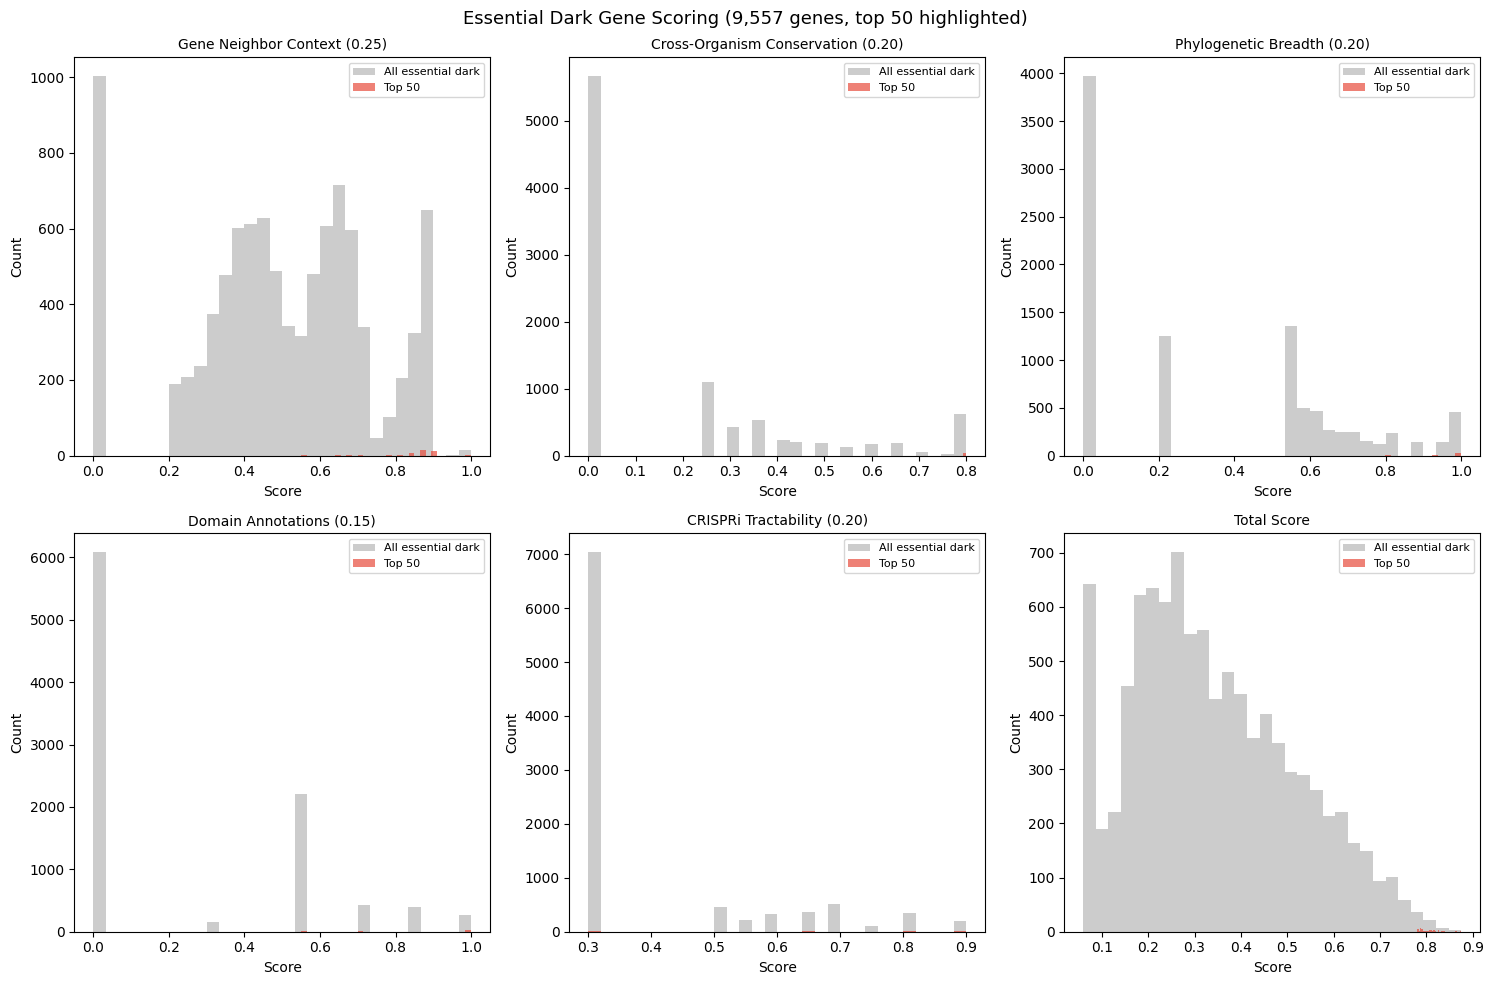

Saved fig19_essential_scores.png


In [14]:
# Figure 19: Essential gene score distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

component_names = {
    's_neighbor': 'Gene Neighbor Context (0.25)',
    's_conservation': 'Cross-Organism Conservation (0.20)',
    's_breadth': 'Phylogenetic Breadth (0.20)',
    's_domains': 'Domain Annotations (0.15)',
    's_tractability': 'CRISPRi Tractability (0.20)',
    'total_score': 'Total Score',
}

top50 = ess_scores_df.head(50)

for ax, (col, name) in zip(axes.flat, component_names.items()):
    ax.hist(ess_scores_df[col], bins=30, alpha=0.4, color='gray', label='All essential dark')
    ax.hist(top50[col], bins=30, alpha=0.7, color='#e74c3c', label='Top 50')
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    ax.set_title(name, fontsize=10)
    ax.legend(fontsize=8)

plt.suptitle(f'Essential Dark Gene Scoring ({len(ess_scores_df):,} genes, top 50 highlighted)', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig19_essential_scores.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig19_essential_scores.png')

## Section 3: Top-50 Essential Dark Gene Dossiers

Each dossier provides experimentally actionable information: what gene, what organism, what function is predicted, and what specific CRISPRi experiment to run.

In [15]:
# Build dossiers for top 50
top50 = ess_scores_df.head(50).copy()

def build_essential_hypothesis(row):
    """Construct best functional hypothesis for an essential dark gene."""
    parts = []
    confidence = 'low'
    
    # Operon-based inference (strongest for essentials)
    operon_desc = str(row.get('operon_annotated_descs', ''))
    if operon_desc and operon_desc not in ('', 'nan'):
        parts.append(f'Operon context: {operon_desc[:100]}')
        confidence = 'medium'
    
    # Neighbor inference
    neighbor_inf = str(row.get('neighbor_functional_inference', ''))
    if neighbor_inf and neighbor_inf not in ('', 'nan') and not operon_desc:
        parts.append(f'Neighbor context: {neighbor_inf[:80]}')
        if confidence == 'low':
            confidence = 'low-medium'
    
    # Module prediction
    pred = str(row.get('module_prediction', ''))
    if pred and pred not in ('', 'nan'):
        parts.append(f'Module prediction: {pred}')
        confidence = 'medium' if confidence == 'low' else confidence
    
    # Essential prediction from essential_genome project
    epred = str(row.get('essential_prediction', ''))
    if epred and epred not in ('', 'nan'):
        parts.append(f'Essential gene prediction: {epred}')
        if confidence in ('low', 'low-medium'):
            confidence = 'medium'
    
    # Domain annotations
    domains = str(row.get('domain_names', ''))
    if domains and domains not in ('', 'nan'):
        parts.append(f'Domains: {domains}')
    
    # Functional keywords
    func_kw = str(row.get('func_keywords', ''))
    if func_kw and func_kw not in ('', 'nan'):
        parts.append(f'Functional neighborhood: {func_kw}')
    
    # Multiple converging evidence raises confidence
    if len(parts) >= 3 and confidence == 'medium':
        confidence = 'high'
    elif len(parts) >= 2 and confidence == 'low-medium':
        confidence = 'medium'
    
    hypothesis = ' | '.join(parts) if parts else 'No functional clues beyond essentiality'
    return hypothesis, confidence


# Organism-specific CRISPRi references and media recommendations
CRISPRI_REFS = {
    'Keio': 'Peters et al. 2016 (Cell)',
    'BW25113': 'Peters et al. 2016 (Cell)',
    'Deshi': 'Peters et al. 2016 (Cell)',
    'MR1': 'Peters et al. 2019 (mBio)',
    'SB2B': 'Peters et al. 2019 (mBio)',
    'Putida': 'Tan et al. 2018 (Metab Eng)',
    'pseudo5_N2C3_1': 'Tan et al. 2018 (Metab Eng)',
    'pseudo1_N1B4': 'Tan et al. 2018 (Metab Eng)',
    'pseudo3_N2E2': 'Tan et al. 2018 (Metab Eng)',
    'BT': 'Mimee et al. 2015 (ACS Synth Biol)',
}

MEDIA_BY_CONDITION = {
    'iron': 'M9 minimal + 0.2% glucose, ± 100 µM FeCl3',
    'sulfur': 'M9 minimal + 0.2% glucose, ± 1 mM MgSO4',
    'transport': 'M9 minimal + varied carbon (glucose, acetate, citrate at 0.2%)',
    'nitrogen': 'M9 minimal + 0.2% glucose, ± 10 mM NH4Cl',
    'ribosom': 'LB at 37°C, monitor growth rate at OD600',
    'membrane': 'M9 minimal + 0.2% glucose + sub-MIC SDS (0.001%)',
    'regulator': 'M9 minimal + 0.2% glucose, ± osmotic stress (0.3M NaCl)',
}


def suggest_crispri_experiment(row):
    """Design a specific CRISPRi experiment for an essential dark gene."""
    org = row['orgId']
    locus = row['locusId']
    crispri_score = CRISPRI_TRACTABILITY.get(org, DEFAULT_CRISPRI)
    
    # Determine condition based on functional clues
    func_kw = str(row.get('func_keywords', ''))
    operon_desc = str(row.get('operon_annotated_descs', '')).lower()
    
    # Match best media condition
    media = 'LB rich media at 37°C'
    expected = 'growth rate reduction vs non-targeting control'
    
    for kw, media_spec in MEDIA_BY_CONDITION.items():
        if kw in func_kw or kw in operon_desc:
            media = media_spec
            expected = f'enhanced growth defect under {kw}-related conditions'
            break
    
    # Build experiment protocol
    parts = [
        f'sgRNA design: Target within first 50% of {locus} ORF on template strand (20 nt + PAM)',
        f'Host: {org}',
        f'Media: {media}',
        f'Controls: (1) non-targeting sgRNA control, (2) uninduced dCas9 control',
        f'Readout: OD600 at 0, 6, 12, 24h in 96-well plates (n=3 biological replicates)',
        f'Success criterion: >20% OD600 reduction vs non-targeting control at 12h (p<0.05, t-test)',
        f'Validation: complement with WT {locus} on expression plasmid to confirm specificity',
    ]
    
    # Add organism-specific reference
    ref = CRISPRI_REFS.get(org, '')
    if ref:
        parts.append(f'CRISPRi reference: {ref}')
    elif crispri_score < 0.5:
        parts.append(f'Note: CRISPRi not yet established for {org}; consider E. coli heterologous expression')
    
    return '; '.join(parts)


# Apply to top 50
hypotheses = []
experiments = []
confidences = []

for _, row in top50.iterrows():
    hyp, conf = build_essential_hypothesis(row)
    hypotheses.append(hyp)
    confidences.append(conf)
    experiments.append(suggest_crispri_experiment(row))

top50['functional_hypothesis'] = hypotheses
top50['hypothesis_confidence'] = confidences
top50['suggested_experiment'] = experiments

print('Top 50 essential dark gene dossiers:')
print(f'  Hypothesis confidence: {top50["hypothesis_confidence"].value_counts().to_string()}')
print(f'  Organisms: {top50["orgId"].nunique()}')
print(f'  Score range: {top50["total_score"].min():.3f} – {top50["total_score"].max():.3f}')

Top 50 essential dark gene dossiers:
  Hypothesis confidence: hypothesis_confidence
high    50
  Organisms: 15
  Score range: 0.780 – 0.875


In [16]:
# Display top 20 essential dark gene candidates
print('=' * 80)
print('TOP 20 ESSENTIAL DARK MATTER CANDIDATES')
print('=' * 80)

for i, (_, row) in enumerate(top50.head(20).iterrows()):
    print(f'\n--- Rank {i+1} (score: {row["total_score"]:.3f}) ---')
    print(f'  Gene: {row["orgId"]}:{row["locusId"]}')
    print(f'  Description: {row["desc"]}')
    print(f'  Domains: {row["domain_names"]}')
    print(f'  Orthologs in {_safe_int(row.get("n_ortholog_organisms", 0))} other FB organisms')
    print(f'  Operon annotated partners: {_safe_int(row.get("n_operon_annotated", 0))}')
    if row.get('operon_annotated_descs') and str(row['operon_annotated_descs']) != 'nan':
        print(f'  Operon context: {str(row["operon_annotated_descs"])[:100]}')
    print(f'  Scores: nb={row["s_neighbor"]:.2f} cons={row["s_conservation"]:.2f} '
          f'br={row["s_breadth"]:.2f} dom={row["s_domains"]:.2f} tr={row["s_tractability"]:.2f}')
    print(f'  Hypothesis ({row["hypothesis_confidence"]}): {row["functional_hypothesis"][:150]}')
    print(f'  Experiment: {row["suggested_experiment"][:150]}')

TOP 20 ESSENTIAL DARK MATTER CANDIDATES

--- Rank 1 (score: 0.875) ---
  Gene: Keio:14796
  Description: hypothetical protein (NCBI)
  Domains: YbeY | TIGR00043
  Orthologs in 27 other FB organisms
  Operon annotated partners: 2
  Operon context: predicteed ion transport (NCBI) | predicted protein with nucleoside triphosphate hydrolase domain (R
  Scores: nb=0.90 cons=0.80 br=0.80 dom=1.00 tr=0.90
  Hypothesis (high): Operon context: predicteed ion transport (NCBI) | predicted protein with nucleoside triphosphate hydrolase domain (R | Domains: YbeY | TIGR00043 | Fun
  Experiment: sgRNA design: Target within first 50% of 14796 ORF on template strand (20 nt + PAM); Host: Keio; Media: M9 minimal + varied carbon (glucose, acetate, 

--- Rank 2 (score: 0.874) ---
  Gene: MR1:200382
  Description: conserved hypothetical protein (NCBI ptt file)
  Domains: RimP_N | DUF150_C
  Orthologs in 28 other FB organisms
  Operon annotated partners: 2
  Operon context: tRNA-Met (RefSeq) | N utilization s

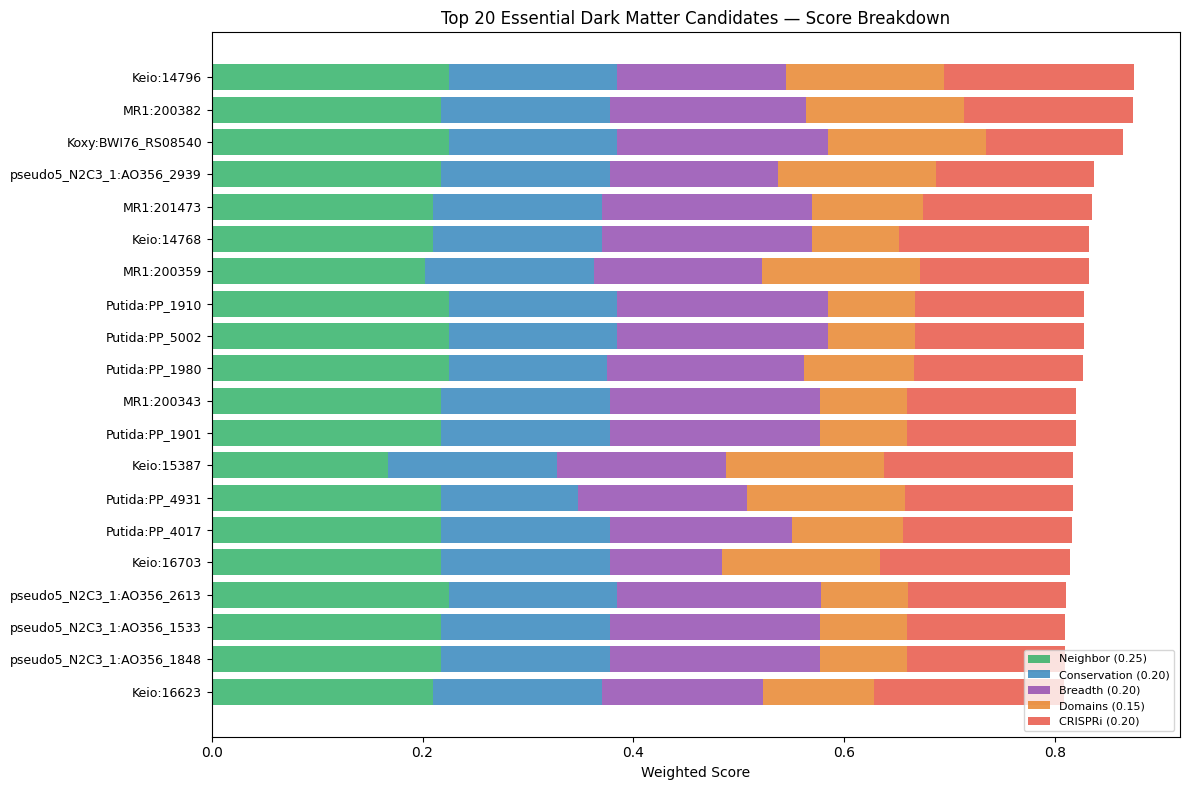

Saved fig20_essential_top20.png


In [17]:
# Figure 20: Top 20 essential candidates stacked bar
fig, ax = plt.subplots(figsize=(12, 8))

top20 = top50.head(20).copy()
labels = [f'{row["orgId"]}:{row["locusId"]}' for _, row in top20.iterrows()]
labels = [l[:25] for l in labels]

y_pos = np.arange(len(top20))
colors = ['#27AE60', '#2980B9', '#8E44AD', '#E67E22', '#E74C3C']
component_keys = ['s_neighbor', 's_conservation', 's_breadth', 's_domains', 's_tractability']
component_labels = ['Neighbor', 'Conservation', 'Breadth', 'Domains', 'CRISPRi']
weights = list(ESSENTIAL_WEIGHTS.values())

left = np.zeros(len(top20))
for i, (key, label) in enumerate(zip(component_keys, component_labels)):
    vals = top20[key].values * weights[i]
    ax.barh(y_pos, vals, left=left, color=colors[i],
            label=f'{label} ({weights[i]:.2f})', alpha=0.8)
    left += vals

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Weighted Score')
ax.set_title('Top 20 Essential Dark Matter Candidates — Score Breakdown')
ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig20_essential_top20.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig20_essential_top20.png')

In [18]:
# Save all outputs
ess_scores_df.to_csv(os.path.join(DATA_DIR, 'essential_dark_scored.tsv'), sep='\t', index=False)
print(f'Saved essential_dark_scored.tsv ({len(ess_scores_df):,} genes)')

top50.to_csv(os.path.join(DATA_DIR, 'essential_prioritized_candidates.tsv'), sep='\t', index=False)
print(f'Saved essential_prioritized_candidates.tsv ({len(top50)} candidates)')

Saved essential_dark_scored.tsv (9,557 genes)
Saved essential_prioritized_candidates.tsv (50 candidates)


## Section 4: Summary

In [19]:
print('=' * 70)
print('NB07 SUMMARY: ESSENTIAL DARK GENE PRIORITIZATION')
print('=' * 70)

print(f'\n--- Gene Neighbor Analysis ---')
print(f'Dark genes analyzed: {len(neighbor_df):,}')
print(f'  With annotated neighbors: {(neighbor_df["n_annotated_neighbors"] > 0).sum():,} ({100*(neighbor_df["n_annotated_neighbors"] > 0).sum()/len(neighbor_df):.1f}%)')
print(f'  With operon partners: {(neighbor_df["n_operon_partners"] > 0).sum():,}')
print(f'  With annotated operon partners: {(neighbor_df["n_operon_annotated"] > 0).sum():,}')
print(f'  With functional inference: {(neighbor_df["neighbor_functional_inference"] != "").sum():,}')

print(f'\n--- Essential Dark Gene Scoring ---')
print(f'Genes scored: {len(ess_scores_df):,}')
print(f'Score range: {ess_scores_df["total_score"].min():.3f} – {ess_scores_df["total_score"].max():.3f}')
print(f'Median score: {ess_scores_df["total_score"].median():.3f}')

print(f'\n--- Top 50 Essential Candidates ---')
print(f'Score range: {top50["total_score"].min():.3f} – {top50["total_score"].max():.3f}')
print(f'Organisms: {top50["orgId"].nunique()}')
print(f'Hypothesis confidence:')
print(f'  {top50["hypothesis_confidence"].value_counts().to_string()}')
print(f'With neighbor-based inference: {(top50["s_neighbor"] > 0.3).sum()}')
print(f'With cross-organism orthologs: {(top50["n_ortholog_organisms"].fillna(0) > 0).sum()}')

print(f'\n--- Output Files ---')
for f in ['gene_neighbor_context.tsv', 'essential_dark_scored.tsv', 'essential_prioritized_candidates.tsv']:
    fp = os.path.join(DATA_DIR, f)
    if os.path.exists(fp):
        print(f'  {f}: {os.path.getsize(fp)/1024:.1f} KB')
for f in ['fig18_neighbor_analysis.png', 'fig19_essential_scores.png', 'fig20_essential_top20.png']:
    fp = os.path.join(FIG_DIR, f)
    if os.path.exists(fp):
        print(f'  {f}')

print('\n' + '=' * 70)

NB07 SUMMARY: ESSENTIAL DARK GENE PRIORITIZATION

--- Gene Neighbor Analysis ---
Dark genes analyzed: 57,011
  With annotated neighbors: 55,422 (97.2%)
  With operon partners: 45,848
  With annotated operon partners: 30,190
  With functional inference: 55,422

--- Essential Dark Gene Scoring ---
Genes scored: 9,557
Score range: 0.060 – 0.875
Median score: 0.312

--- Top 50 Essential Candidates ---
Score range: 0.780 – 0.875
Organisms: 15
Hypothesis confidence:
  hypothesis_confidence
high    50
With neighbor-based inference: 50
With cross-organism orthologs: 50

--- Output Files ---
  gene_neighbor_context.tsv: 14852.6 KB
  essential_dark_scored.tsv: 2168.6 KB
  essential_prioritized_candidates.tsv: 55.0 KB
  fig18_neighbor_analysis.png
  fig19_essential_scores.png
  fig20_essential_top20.png



## Scoring Robustness Check

Test whether the top-ranked essential dark gene candidates are sensitive to arbitrary weight choices by re-scoring under 6 alternative weight configurations and measuring rank stability.

In [20]:
# Scoring sensitivity analysis for NB07 essential gene prioritization
from scipy.stats import spearmanr

# Load scored data
scored = pd.read_csv(os.path.join(DATA_DIR, 'essential_dark_scored.tsv'), sep='\t')
component_cols = ['s_neighbor', 's_conservation', 's_breadth', 's_domains', 's_tractability']

# Weight configurations to test
weight_configs = {
    'original': {'neighbor': 0.25, 'conservation': 0.20, 'breadth': 0.20, 'domains': 0.15, 'tractability': 0.20},
    'equal': {'neighbor': 0.20, 'conservation': 0.20, 'breadth': 0.20, 'domains': 0.20, 'tractability': 0.20},
    'neighbor_dominant': {'neighbor': 0.40, 'conservation': 0.15, 'breadth': 0.15, 'domains': 0.15, 'tractability': 0.15},
    'conservation_dominant': {'neighbor': 0.15, 'conservation': 0.40, 'breadth': 0.15, 'domains': 0.15, 'tractability': 0.15},
    'drop_tractability': {'neighbor': 0.3125, 'conservation': 0.25, 'breadth': 0.25, 'domains': 0.1875, 'tractability': 0.0},
    'drop_neighbor': {'neighbor': 0.0, 'conservation': 0.2667, 'breadth': 0.2667, 'domains': 0.20, 'tractability': 0.2667},
}

# Original ranking
original_scores = scored['total_score'].values
original_rank = scored['total_score'].rank(ascending=False).values
original_top50 = set(scored.nlargest(50, 'total_score').index)

results = []
for config_name, weights in weight_configs.items():
    # Compute new total score
    new_score = sum(scored[f's_{dim}'] * w for dim, w in weights.items())
    new_rank = new_score.rank(ascending=False).values
    
    # Spearman rank correlation with original
    rho, p = spearmanr(original_rank, new_rank)
    
    # Top-50 overlap
    new_top50 = set(new_score.nlargest(50).index)
    overlap_50 = len(original_top50 & new_top50)
    
    results.append({
        'config': config_name,
        'spearman_rho': rho,
        'spearman_p': p,
        'top50_overlap': overlap_50,
        'top50_pct': 100 * overlap_50 / 50,
        'weights': str(weights),
    })

sensitivity_nb07 = pd.DataFrame(results)
print('NB07 Essential Gene Scoring Sensitivity Analysis')
print('=' * 60)
for _, row in sensitivity_nb07.iterrows():
    print(f'  {row["config"]:25s}  rho={row["spearman_rho"]:.4f}  '
          f'top-50 overlap={row["top50_overlap"]}/50 ({row["top50_pct"]:.0f}%)')

# Summary statistics
non_original = sensitivity_nb07[sensitivity_nb07['config'] != 'original']
min_rho = non_original['spearman_rho'].min()
mean_rho = non_original['spearman_rho'].mean()
min_overlap = non_original['top50_overlap'].min()
mean_overlap = non_original['top50_pct'].mean()

print(f'\nAcross 5 alternative configurations:')
print(f'  Rank correlation range: {min_rho:.4f} – {non_original["spearman_rho"].max():.4f} (mean={mean_rho:.4f})')
print(f'  Top-50 overlap range: {min_overlap}/50 – {non_original["top50_overlap"].max()}/50 (mean={mean_overlap:.0f}%)')

if min_rho > 0.95 and min_overlap >= 45:
    print(f'\n  ROBUST: Rankings stable under all weight perturbations')
elif min_rho > 0.85 and min_overlap >= 35:
    print(f'\n  MODERATELY ROBUST: Rankings mostly stable')
else:
    print(f'\n  FRAGILE: Rankings sensitive to weight choices — report as limitation')

# Save
sensitivity_nb07.to_csv(os.path.join(DATA_DIR, 'scoring_sensitivity_nb07.tsv'), sep='\t', index=False)
print(f'\nSaved scoring_sensitivity_nb07.tsv')

NB07 Essential Gene Scoring Sensitivity Analysis
  original                   rho=1.0000  top-50 overlap=50/50 (100%)
  equal                      rho=0.9966  top-50 overlap=44/50 (88%)
  neighbor_dominant          rho=0.9799  top-50 overlap=43/50 (86%)
  conservation_dominant      rho=0.9813  top-50 overlap=42/50 (84%)
  drop_tractability          rho=0.9784  top-50 overlap=18/50 (36%)
  drop_neighbor              rho=0.9381  top-50 overlap=24/50 (48%)

Across 5 alternative configurations:
  Rank correlation range: 0.9381 – 0.9966 (mean=0.9749)
  Top-50 overlap range: 18/50 – 44/50 (mean=68%)

  FRAGILE: Rankings sensitive to weight choices — report as limitation

Saved scoring_sensitivity_nb07.tsv
